In [1]:
import os
import random
import torch
import gpytorch
import gpinfuser
import numpy as np
import matplotlib.pyplot as plt

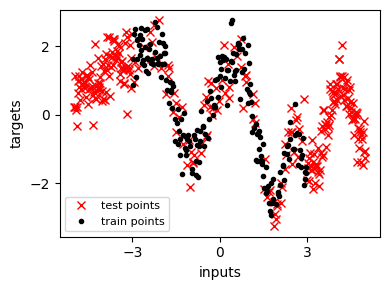

In [2]:
# Base GP model
class GP(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train):
        super().__init__(x_train, y_train, gpytorch.likelihoods.GaussianLikelihood())
        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel()
        )

    def forward(self, x):
        function_mean = self.mean_module(x)
        function_covar = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(function_mean, function_covar)

# Sampling function
def f(x):
    gp = GP(x, torch.randn(len(x)))
    gp.covar_module.outputscale = 1.0
    gp.covar_module.base_kernel.lengthscale = 0.5
    gp.likelihood.noise = 0.2
    with torch.no_grad():
        targets_dist = gp.likelihood(gp(x))
    return targets_dist.rsample(), gp

# Build input data, initialize the GP, and sample from it
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

x = torch.linspace(-5, 5, 500)
y, gp = f(x)
train_mask = (x > -3) & (x < 3)
to_false = torch.randperm(len(x))[:(train_mask.sum() * 0.5).int()]
train_mask[to_false] = False

x_train = x[train_mask].reshape(-1, 1)
y_train = y[train_mask]
x_test = x[~train_mask].reshape(-1, 1)
y_test = y[~train_mask]

fig, ax = plt.subplots(figsize=[4, 3])
ax.plot(x_test, y_test, 'x', color='r', label='test points')
ax.plot(x_train, y_train, '.', color='k', label='train points')
ax.set_xlabel('inputs')
ax.set_ylabel('targets')
ax.set_xticks([-3, 0, 3])
ax.set_yticks([-2, 0, 2])
ax.legend(fontsize=8)
fig.tight_layout()
plt.show()

In [3]:
def get_mean():
    return gpytorch.means.ZeroMean()

def get_kernel(num_features):
    kernel = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    kernel.initialize(**{'outputscale': y_train.var(), 'base_kernel.lengthscale': 1})
    return kernel

def get_likelihood():
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    likelihood.initialize(**{'noise': y_train.var() * 0.01})
    return likelihood

def get_amortized_svgp(num_inducing, num_features):
    return gpinfuser.models.AmortizedSVGP(get_mean(), get_kernel(num_features), num_inducing, 1)

def get_feature_extractor(num_features, nonlinearity, norm_layer=torch.nn.BatchNorm1d):
    return gpinfuser.nn.MLP(
        in_features=x_train.size(1),
        hidden_dim=[32, num_features],
        nonlinearity=nonlinearity,
        norm_layer=norm_layer
    )

def get_variational_module(in_features, num_features, num_inducing, saturation):
    return gpinfuser.nn.Variational(
        in_features=in_features,
        num_tasks=1,
        num_inducing=num_inducing,
        num_features=num_features,
        saturation=saturation
    )

def get_amortized_variational_dkl(num_features, num_inducing, nonlinearity, saturation):
    feature_extractor = get_feature_extractor(num_features, nonlinearity)
    variational_module = get_variational_module(num_features, num_features, num_inducing, saturation)
    gplayer = get_amortized_svgp(num_inducing, num_features)
    return gpinfuser.models.AVDKL(feature_extractor, variational_module, gplayer, get_likelihood())

def get_optimizer(model, lr=0.003, weight_decay=1e-4):
    return torch.optim.AdamW([
        {'params': model.feature_extractor.parameters(), 'weight_decay': weight_decay},
        {'params': model.variational_estimator.parameters(), 'weight_decay': weight_decay},
        {'params': model.gplayer.hyperparameters(), 'lr': lr * 0.1},
        {'params': model.likelihood.parameters()}
    ], lr=lr, weight_decay=0)

def get_scheduler(optimizer, epochs):
    return torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

def train(model, optimizer, scheduler=None, epochs=1000):
    def step():
        model.train()
        # Compute the evidence lower bound
        function_dist = model(x_train)
        elbo = mll(function_dist, y_train)
        # Prepare optimizer and backward gradients
        optimizer.zero_grad()
        (-elbo).backward()
        optimizer.step()
        return elbo.item()

    @torch.inference_mode()
    def evaluate(x, y):
        model.eval()
        y_dist = model.predict(x)
        y_mean = y_dist.mean.squeeze()
        y_variance = y_dist.variance.squeeze()
        return gpinfuser.metrics.reg_negative_log_likelihood(y, y_mean, y_variance)

    mll = gpytorch.mlls.VariationalELBO(model.likelihood, model.gplayer, len(x_train))
    pbar = gpinfuser.utils.Progbar(epochs, prefix='Training')
    train_curve = []
    train_mnll, test_mnll = [], []

    for _ in range(epochs):
        elbo = step()
        temp_train_mnll = evaluate(x_train, y_train)
        temp_test_mnll = evaluate(x_test, y_test)

        if scheduler is not None:
            scheduler.step()

        train_curve.append(elbo)
        train_mnll.append(temp_train_mnll)
        test_mnll.append(temp_test_mnll)

        pbar.set_postfix({
            'elbo': round(elbo, 3),
            'train_mnll': round(temp_train_mnll, 3),
            'test_mnll': round(temp_test_mnll, 3)
        })
        pbar.step()

    pbar.close()

    return train_curve, train_mnll, test_mnll

def plot_confidence_region(model):
    targets_dist = model.predict(x_test)
    y_mean = targets_dist.mean.squeeze()
    y_lower, y_upper = targets_dist.confidence_region()
    y_lower, y_upper = y_lower.squeeze(), y_upper.squeeze()

    plt.figure(figsize=[4, 3])
    plt.plot(x_train, y_train, '.', color='k', label='training points')
    plt.plot(x_test, y_mean, color='r', linewidth=1, label='posterior mean')
    plt.fill_between(x_test.squeeze(), y_lower, y_upper, color='r', alpha=0.12)
    plt.xticks([])
    plt.yticks([-2.5, 0, 2.5])
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.title('Mean posterior with confidence intervals', size=10, style='italic')
    plt.legend(fontsize=8)
    plt.tight_layout()
    plt.show()

In [4]:
avdkl = get_amortized_variational_dkl(
    num_features=12,
    num_inducing=2,
    nonlinearity=torch.nn.SiLU(),
    saturation=torch.nn.Tanh()
)
optimizer = get_optimizer(avdkl, lr=0.01, weight_decay=0.001)
scheduler = get_scheduler(optimizer, epochs=2000)
train_elbo, train_mnll, test_mnll = train(avdkl, optimizer, epochs=2000)

Training |..............................| 100.0% - elbo=-0.6960, train_mnll=0.6380, test_mnll=1.3690


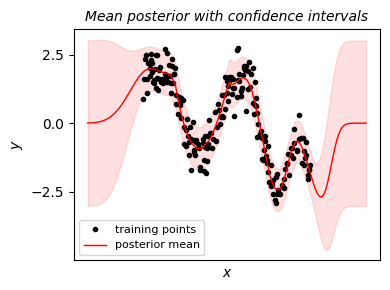

In [5]:
plot_confidence_region(avdkl)

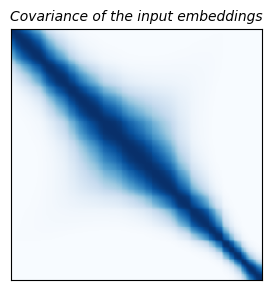

In [6]:
avdkl.eval()
with torch.inference_mode():
    x_emb = avdkl.feature_extractor(x_train)
    kernel = avdkl.gplayer.covar_module(x_emb).evaluate()

plt.figure(figsize=[4, 3])
plt.imshow(kernel, cmap='Blues')
plt.title('Covariance of the input embeddings', size=10, style='italic')
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()